# Age and Pathogenicity

It seems that older people have more pathogens.

Do they? Can we separate that from hospital effects?

## Repeat the initial observation

I showed this in the mgi_metadata_pcas.ipynb notebook, but we also showed it elsewhere

In [14]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import linregress

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set up the functions

In [2]:
corrections = {
    "MGI" : { 
        '1112926_20171212_S' : '1447437_20171212_S',
        '1128691_20170206_S' : '1128691_20171206_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '1723809_20180227_S' : '1085876_20180227_S',
        '649354_20170206_S' : '639354_20171206_S',
        '652927_20180226_S' : '715927_20180226_S',
        '658355_20180301_S' : '658355_20180327_S',
        '777851_20170918_S' : '778851_20170918_S',
        '788707_20181126_S' : '788707_20181129_S'
    },
    "minion" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '698917_20190119_S' : '698917_20180119_S'
        }
}

pathogens = {
    "Streptococcus",
    "Staphylococcus",
    "Haemophilus",
    "Mycobacterium",
    "Pseudomonas",
    "Klebsiella",
    "Moraxella",
    "Bordetella",
    "Legionella",
    "Corynebacterium",
    "Chlamydia",
    "Mycoplasma",
    "Neisseria",
    "Burkholderia",
    "Acinetobacter",
    "Francisella",
    "Escherichia",
    "Pasteurella",
    "Nocardia",
    "Actinomyces"
}

def read_taxonomy(tax_file, firstchar, sequence_type):
    """
    Read the taxonomy file and return a data frame
    """
    
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None
       
    df = pd.read_csv(tax_file, sep='\t', compression='gzip')
    df = df[df['taxonomy'].str.contains('k__Bacteria')]
    df = df[~df['taxonomy'].str.endswith(f'{firstchar}__')]
    df = df.set_index('taxonomy')
    df = df.rename(columns=corrections[sequence_type])
    df.index = df.index.str.replace(f'{firstchar}__', '').str.replace('Candidatus ', '')
    df.index = df.index.str.split(';').str[-1]
    
    df = df.sort_index(axis=1)
    return df

def read_metadata(sequence_type):
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None
    
    metadata = pd.read_csv("../Metadata/Metadata.txt", encoding='windows-1252', sep="\t", index_col=0)
    metadata = metadata[~metadata[sequence_type].isna()]

    for ix in metadata.index:
        s = metadata.loc[ix, sequence_type]
        if s in corrections[sequence_type]:
            metadata.loc[ix, sequence_type] = corrections[sequence_type][s]
    return metadata

def sorted_presence_absence(df1, df2, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]
    
    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2

    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]
    
    # combine the two matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

## Load the data

In [3]:
tax='genus'
# read the data 
mgi_df = read_taxonomy(f"../MGI/Taxonomy/MGI_reads_{tax}.normalised.tsv.gz", tax[0], "mgi")
min_df = read_taxonomy(f"../MinION/Taxonomy/Minion_read_based_annotations_{tax}.normalised.tsv.gz", tax[0], "minion")
mgi_metadata = read_metadata("MGI")
minion_metadata = read_metadata("minion")
sequence_type = "MGI"
# sequence_type = "minion"

if sequence_type == "MGI":
    df = mgi_df
    metadata = mgi_metadata
else:
    df = min_df
    metadata = minion_metadata

metadata = metadata[~metadata[sequence_type].isna()]

In [4]:
df

,1068841_20180306_S,1085876_20180227_S,1128691_20171206_S,1128691_20171218_S,1128691_20180116_S,1162967_20180116_S,1282052_20180206_S,1316935_20180417_S,1447437_20171006_S,1447437_20171212_S,...,825012_20181126_S,848255_20190228_S,875028_20180115_S,877469_20190115_S,892355_20180123_S,895293_20180502_S,896213_20180427_S,913873_20180417_S,980574_20180403_S,983493_20180123_S
taxonomy,,,,,,,,,,,,,,,,,,,,,
Aegiribacteria,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.243915,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Kapaibacterium,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Stahlbacteria,0.539042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.243915,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Vermiphilus,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Babela,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Roseimicrobium,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,6.468389,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Sulfuriroseicoccus,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Verrucomicrobium,0.539042,0.850518,0.0,0.0,0.0,0.0,0.0,0.0,0.862331,0.0,...,0.000000,0.000000,0.000000,0.000000,6.604344,0.0,15.980057,0.0,0.0,0.0


In [5]:
df['pathogen'] = df.index.isin(pathogens)
df

,1068841_20180306_S,1085876_20180227_S,1128691_20171206_S,1128691_20171218_S,1128691_20180116_S,1162967_20180116_S,1282052_20180206_S,1316935_20180417_S,1447437_20171006_S,1447437_20171212_S,...,848255_20190228_S,875028_20180115_S,877469_20190115_S,892355_20180123_S,895293_20180502_S,896213_20180427_S,913873_20180417_S,980574_20180403_S,983493_20180123_S,pathogen
taxonomy,,,,,,,,,,,,,,,,,,,,,
Aegiribacteria,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.243915,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
Kapaibacterium,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
Stahlbacteria,0.539042,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.243915,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
Vermiphilus,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
Babela,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Roseimicrobium,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
Sulfuriroseicoccus,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,False
Verrucomicrobium,0.539042,0.850518,0.0,0.0,0.0,0.0,0.0,0.0,0.862331,0.0,...,0.000000,0.000000,0.000000,6.604344,0.0,15.980057,0.0,0.0,0.0,False


## Calculate the proportion of bacteria per pwCF that are pathogenic

In [6]:
# separate pathogen/non pathogens and calculate the sums per patient
pathogens = df[df['pathogen'] == True].drop(columns='pathogen')
non_pathogens = df[df['pathogen'] == False].drop(columns='pathogen')
total_pathogen = pathogens.sum()
total_non_pathogen = non_pathogens.sum()
total_counts = df.drop(columns='pathogen').sum()

# calculate the proportions and make them a df
proportion_pathogen = total_pathogen / total_counts
proportion_non_pathogen = total_non_pathogen / total_counts
proportions = pd.DataFrame({
    'Proportion Pathogen': proportion_pathogen,
    'Proportion Non-Pathogen': proportion_non_pathogen
})
proportions


,Proportion Pathogen,Proportion Non-Pathogen
1068841_20180306_S,0.606074,0.393926
1085876_20180227_S,0.622765,0.377235
1128691_20171206_S,0.906272,0.093728
1128691_20171218_S,0.862745,0.137255
1128691_20180116_S,0.890358,0.109642
...,...,...
895293_20180502_S,0.635946,0.364054
896213_20180427_S,0.507979,0.492021
913873_20180417_S,0.502764,0.497236
980574_20180403_S,0.437558,0.562442


## Plot a graph of age vs. pathogens

<Axes: xlabel='Age', ylabel='Proportion pathogens'>

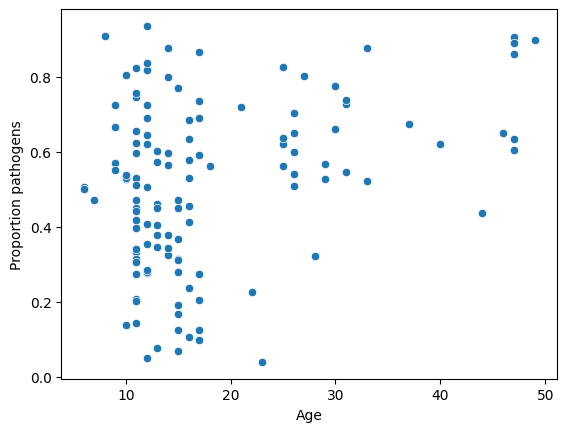

In [13]:
age_pathog = pd.DataFrame()
age_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
age_pathog = age_pathog.join(metadata[['Age']])

sns.scatterplot(data=age_pathog, x='Age', y='Proportion pathogens')

### Add some statistics

In [45]:
# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(age_pathog['Age'], age_pathog['Proportion pathogens'])

print(f"The relationship between 'Age' and 'Proportion pathogens' has an equation of y = {slope:.2f}x + {intercept:.2f}, a Pearson r of {r_value:.2f}, and p={p_value:.2f}")

The relationship between 'Age' and 'Proportion pathogens' has an equation of y = 0.01x + 0.39, a Pearson r of 0.32, and p=0.00


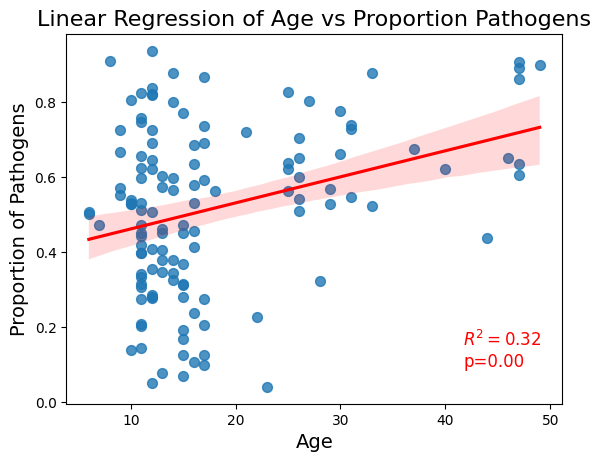

In [27]:
sns.regplot(
    x='Age', y='Proportion pathogens', data=age_pathog, scatter_kws={'s': 50}, line_kws={'color': 'red'}
)

# Annotate the plot with R-squared value
plt.text(
    0.8, 0.1, f"$R^2 = {r_value:.2f}$\np={p_value:.2f}", fontsize=12, transform=plt.gca().transAxes, color='red'
)

# Set labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Proportion of Pathogens', fontsize=14)
plt.title('Linear Regression of Age vs Proportion Pathogens', fontsize=16)
plt.show()


## Proportion pathogens vs. hospital

<Axes: xlabel='Hospital', ylabel='Proportion pathogens'>

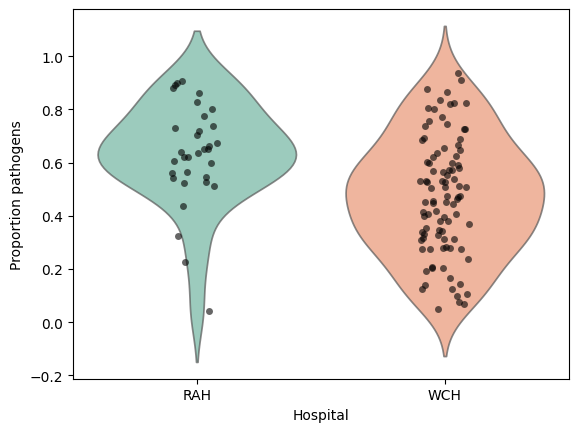

In [29]:
hosp_pathog = pd.DataFrame()
hosp_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
hosp_pathog = hosp_pathog.join(metadata[['Hospital', 'Paediatric vs Adult']])

sns.violinplot(x='Hospital', y='Proportion pathogens', data=hosp_pathog, inner=None, palette='Set2', alpha=0.7)

# Jittered points
sns.stripplot(x='Hospital', y='Proportion pathogens', data=hosp_pathog, color='black', jitter=True, size=5, alpha=0.6)


<Axes: xlabel='Paediatric vs Adult', ylabel='Proportion pathogens'>

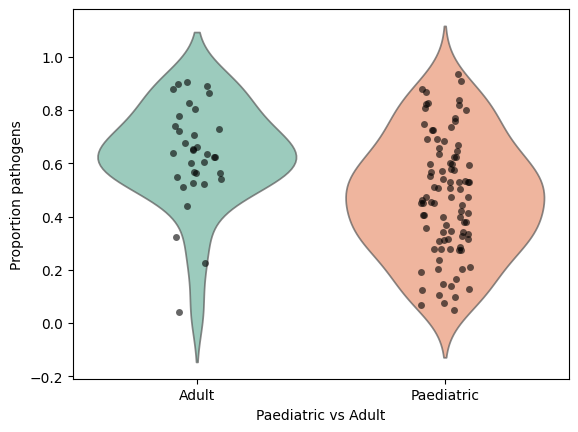

In [30]:
hosp_pathog = pd.DataFrame()
hosp_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
hosp_pathog = hosp_pathog.join(metadata[['Hospital', 'Paediatric vs Adult']])

sns.violinplot(x='Paediatric vs Adult', y='Proportion pathogens', data=hosp_pathog, inner=None, palette='Set2', alpha=0.7)

# Jittered points
sns.stripplot(x='Paediatric vs Adult', y='Proportion pathogens', data=hosp_pathog, color='black', jitter=True, size=5, alpha=0.6)

## FEV1 vs pathogenicity

Oddly, there does not seem to be a strong relationship between the proportion of pathogens and the FEV1. I would have expected there to be a negative relationship, with more pathogens at a lower FEV1/best FEV or FEV1_RATIO_SCORE.

The relationship between FEV1/best FEV1 and Proportion pathogens has an equation of y = nanx + nan, a Pearson r of nan, and p=nan


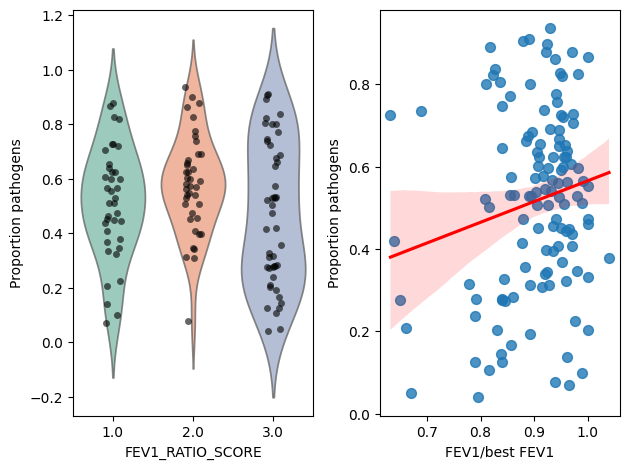

In [46]:
fev_pathog = pd.DataFrame()
fev_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
fev_pathog = fev_pathog.join(metadata[['FEV1/best FEV1', 'FEV1_RATIO_SCORE']])

ax = plt.subplot(121)

sns.violinplot(x='FEV1_RATIO_SCORE', y='Proportion pathogens', data=fev_pathog, inner=None, palette='Set2', alpha=0.7, ax=ax)

# Jittered points
sns.stripplot(x='FEV1_RATIO_SCORE', y='Proportion pathogens', data=fev_pathog, color='black', jitter=True,  size=5, alpha=0.6, ax=ax)

ax = plt.subplot(122)

x='FEV1/best FEV1'
y='Proportion pathogens'
slope, intercept, r_value, p_value, std_err = linregress(fev_pathog[x], fev_pathog[y])

print(f"The relationship between {x} and {y} has an equation of y = {slope:.2f}x + {intercept:.2f}, a Pearson r of {r_value:.2f}, and p={p_value:.2f}")

sns.regplot(x=x, y=y, data=fev_pathog, scatter_kws={'s': 50}, line_kws={'color': 'red'})
#sns.scatterplot(x=x, y=y, data=fev_pathog, color='black', alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()